Map:   0%|          | 0/260505 [00:00<?, ? examples/s]

Map:   0%|          | 0/156304 [00:00<?, ? examples/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Shezan\AppData\Local\Temp\ipykernel_5824\3886650711.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.042000,0.099934,0.939726,0.939778,0.941978,0.939726
2,0.088700,0.093815,0.939970,0.940874,0.945616,0.939970
3,0.046100,0.092446,0.937353,0.938229,0.940491,0.937353


Evaluation Results: {'eval_loss': 0.09381484985351562, 'eval_accuracy': 0.9399695465247211, 'eval_f1': 0.9408738597676253, 'eval_precision': 0.945616053999116, 'eval_recall': 0.9399695465247211, 'eval_runtime': 317.6341, 'eval_samples_per_second': 492.088, 'eval_steps_per_second': 30.756, 'epoch': 3.0}
Evaluation Time: 7064.51 seconds


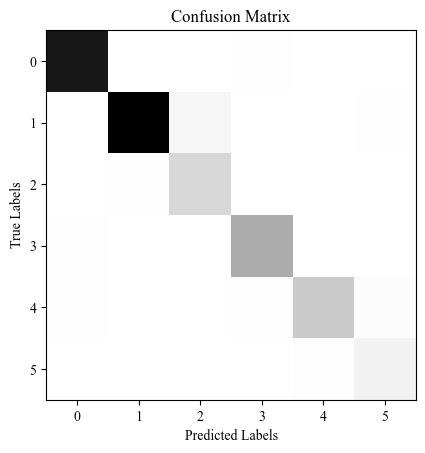

In [2]:
import os
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch

data = pd.read_csv('datasetofsenti.csv')
data = data.drop(columns=["Unnamed: 0"], errors="ignore")

train_texts, test_texts, train_labels, test_labels = train_test_split(
    data["text"], data["label"], test_size=0.375, random_state=42
)

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=len(data["label"].unique()))
model.config.pad_token_id = tokenizer.pad_token_id

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1,
    disable_tqdm=False,
    report_to=[]  # Disables WandB and other third-party integrations
)

def compute_metrics(pred):
    logits, labels = pred
    logits = torch.tensor(logits).to(device)
    labels = torch.tensor(labels).to(device)
    predictions = torch.argmax(logits, axis=-1)
    acc = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
    precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu().numpy(), predictions.cpu().numpy(), average="weighted")
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

start_time = time.time()
trainer.train()
results = trainer.evaluate()
end_time = time.time()
print("Evaluation Results:", results)
print(f"Evaluation Time: {end_time - start_time:.2f} seconds")

test_preds = trainer.predict(test_dataset)
logits = test_preds.predictions
predictions = np.argmax(logits, axis=-1)
cm = confusion_matrix(test_labels, predictions)

plt.figure()
plt.imshow(cm, cmap="Greys")
plt.title("Confusion Matrix", fontname="Times New Roman")
plt.xlabel("Predicted Labels", fontname="Times New Roman")
plt.ylabel("True Labels", fontname="Times New Roman")
plt.xticks(fontname="Times New Roman")
plt.yticks(fontname="Times New Roman")
plt.savefig("confusion_matrix.png", dpi=300)

if len(np.unique(test_labels)) == 2:
    roc_auc = roc_auc_score(test_labels, logits[:, 1])
    fpr, tpr, _ = roc_curve(test_labels, logits[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC-ROC = {roc_auc:.2f}", color="black")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("AUC-ROC Curve", fontname="Times New Roman")
    plt.xlabel("False Positive Rate", fontname="Times New Roman")
    plt.ylabel("True Positive Rate", fontname="Times New Roman")
    plt.legend(fontname="Times New Roman")
    plt.savefig("auc_roc_curve.png", dpi=300)

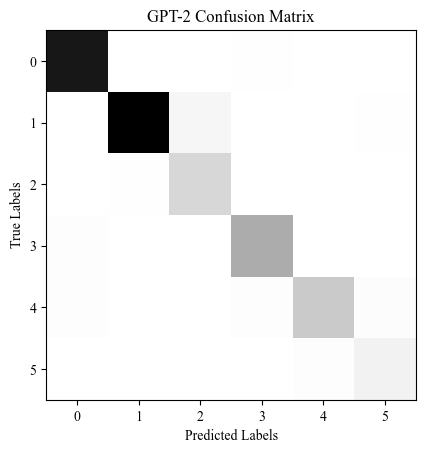

In [4]:
plt.figure()
plt.imshow(cm, cmap="Greys")  # Grayscale color
plt.title("GPT-2 Confusion Matrix", fontname="Times New Roman")
plt.xlabel("Predicted Labels", fontname="Times New Roman")
plt.ylabel("True Labels", fontname="Times New Roman")
plt.xticks(fontname="Times New Roman")
plt.yticks(fontname="Times New Roman")
plt.savefig("optimized_gpt2_confusion_matrix.png", dpi=300)

if len(np.unique(test_labels)) == 2:
    roc_auc = roc_auc_score(test_labels, logits[:, 1])
    fpr, tpr, _ = roc_curve(test_labels, logits[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC-ROC = {roc_auc:.2f}", color="black")  
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  
    plt.title("GPT-2 AUC-ROC Curve", fontname="Times New Roman")
    plt.xlabel("False Positive Rate", fontname="Times New Roman")
    plt.ylabel("True Positive Rate", fontname="Times New Roman")
    plt.legend(prop={"family": "Times New Roman"})
    plt.savefig("optimized_gpt2_auc_roc_curve.png", dpi=300)

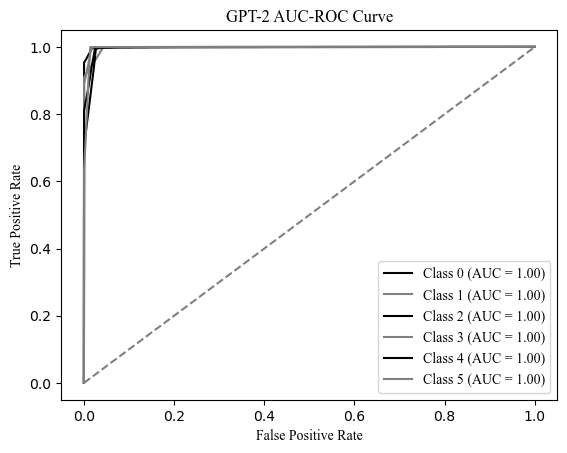

In [8]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc
from itertools import cycle

classes = np.unique(test_labels)
test_labels_bin = label_binarize(test_labels, classes=classes)
n_classes = len(classes)

fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = cycle(["black", "gray"]) 
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray") 
plt.title("GPT-2 AUC-ROC Curve", fontname="Times New Roman")
plt.xlabel("False Positive Rate", fontname="Times New Roman")
plt.ylabel("True Positive Rate", fontname="Times New Roman")
plt.legend(prop={"family": "Times New Roman"})
plt.savefig("optimized_gpt2_multiclass_auc_roc_curve.png", dpi=300)